In [1]:
# =====================================
# 📌 Fuzzy C-Means Clustering (Full Version)
# Dataset: Iris
# Author: Oussama
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from collections import defaultdict
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix as sklearn_cm, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans

In [2]:
# 🔷 1. Data Preparation
# ========================
iris = datasets.load_iris()
X = iris.data
y = iris.target

# ✅ Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data = X_scaled

np.random.seed(42)

In [3]:
# 🔷 2. Parameters
# ========================
m = 2                # fuzziness degree
n = data.shape[0]    # number of samples
c = 3                # number of clusters
p = data.shape[1]    # number of features
max_iter = 100       # maximum iterations

In [4]:
# 🔷 3. Helper Functions
# ========================

def euclidean_distance(point1, point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)

def initialize_membership_matrix(n, c):
    """Initialize random membership matrix with constraints."""
    member_mat = []
    for i in range(n):
        random_list = [random.random() for _ in range(c)]
        summation = sum(random_list)
        random_list = [x / summation for x in random_list]
        member_mat.append(random_list)
    return np.array(member_mat)

def update_centroid(member_mat):
    """Update centroids based on current membership matrix."""
    centroids = []
    for j in range(c):
        num = np.zeros(p)
        den = 0
        for i in range(n):
            weight = member_mat[i][j] ** m
            num += weight * data[i]
            den += weight
        centroids.append(num / den)
    return np.array(centroids)

def update_membership_matrix(member_mat, centroids):
    """Update membership matrix based on new centroids."""
    for i in range(n):
        for j in range(c):
            denom = sum([(euclidean_distance(data[i], centroids[j]) / euclidean_distance(data[i], centroids[k])) ** (2 / (m - 1)) for k in range(c)])
            member_mat[i][j] = 1 / denom
    return member_mat

def check_convergence(old_member_mat, member_mat):
    """Check if membership matrix has converged."""
    return np.linalg.norm(member_mat - old_member_mat) < 0.01

def find_cluster(member_mat):
    """Assign cluster with highest membership degree."""
    return np.argmax(member_mat, axis=1)

In [5]:
# 🔷 4. Fuzzy C-Means Function
# ========================

def fuzzy_c_means():
    member_mat = initialize_membership_matrix(n, c)
    for i in range(max_iter):
        centroids = update_centroid(member_mat)
        old_member_mat = member_mat.copy()
        member_mat = update_membership_matrix(member_mat, centroids)
        if check_convergence(old_member_mat, member_mat):
            print(f"✅ Converged in {i} iterations")
            break
    clusters = find_cluster(member_mat)
    return clusters, centroids, member_mat

In [6]:
# 🔷 5. Run Fuzzy C-Means
# ========================

clusters, centroids, memberships = fuzzy_c_means()

✅ Converged in 15 iterations


In [7]:
# 🔷 6. Label Clusters (Version Longue)
# ========================

def label_clusters(clusters):
    """Map cluster IDs to true classes (specific to Iris dataset)."""
    mapping = {}
    for class_idx in range(3):
        start = class_idx * 50
        end = start + 50
        counts = np.bincount(clusters[start:end], minlength=3)
        mapped_cluster = np.argmax(counts)
        mapping[mapped_cluster] = class_idx
    return mapping

cluster_to_label = label_clusters(clusters)
predicted_labels = np.array([cluster_to_label.get(cl, -1) for cl in clusters])

In [8]:
# 🔷 7. Confusion Matrix (Manual + sklearn)
# ========================

cm = sklearn_cm(y, predicted_labels)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[50  0  0]
 [ 0 39 11]
 [ 0 13 37]]


In [9]:
# 🔷 8. Metrics Class (from original code)
# ========================

class Metrics:
    def __init__(self, confusion_m):
        self.confusion_m = np.array(confusion_m)
        self.total = np.sum(self.confusion_m)
        self.diagonal = np.trace(self.confusion_m)

    def accuracy(self):
        return self.diagonal / self.total

    def recall(self):
        recall_per_class = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=1)
        return np.nanmean(recall_per_class)

    def precision(self):
        precision_per_class = np.diag(self.confusion_m) / np.sum(self.confusion_m, axis=0)
        return np.nanmean(precision_per_class)

    def f1_score(self, precision, recall):
        if precision + recall == 0:
            return 0.0
        return (2 * precision * recall) / (precision + recall)

performance = Metrics(cm)
accuracy = performance.accuracy()
recall = performance.recall()
precision = performance.precision()
f1 = performance.f1_score(precision, recall)

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

Accuracy: 84.00%
Recall: 84.00%
Precision: 84.03%
F1-Score: 84.01%


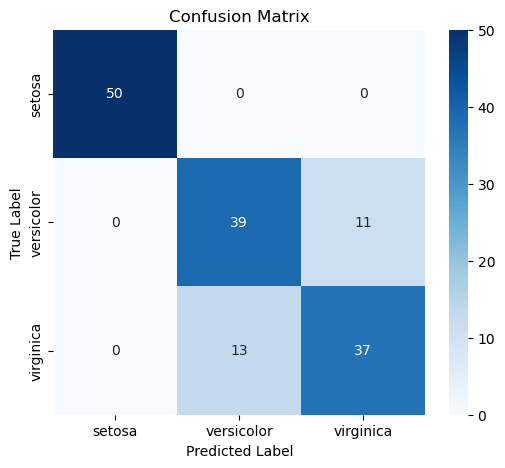

In [10]:
# 🔷 9. Visualisation – Confusion Matrix Heatmap
# ========================

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

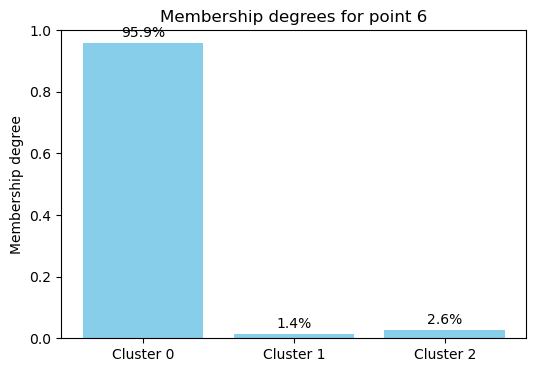

In [11]:
# 🔷 10. Plot Memberships for a specific point
# ========================

def plot_point_membership(memberships, point_idx):
    cluster_ids = list(range(memberships.shape[1]))
    values = memberships[point_idx]

    plt.figure(figsize=(6,4))
    plt.bar(cluster_ids, values, color='skyblue')
    plt.xticks(cluster_ids, [f'Cluster {i}' for i in cluster_ids])
    plt.ylim(0,1)
    plt.ylabel("Membership degree")
    plt.title(f"Membership degrees for point {point_idx}")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center')
    plt.show()

plot_point_membership(memberships, 6)

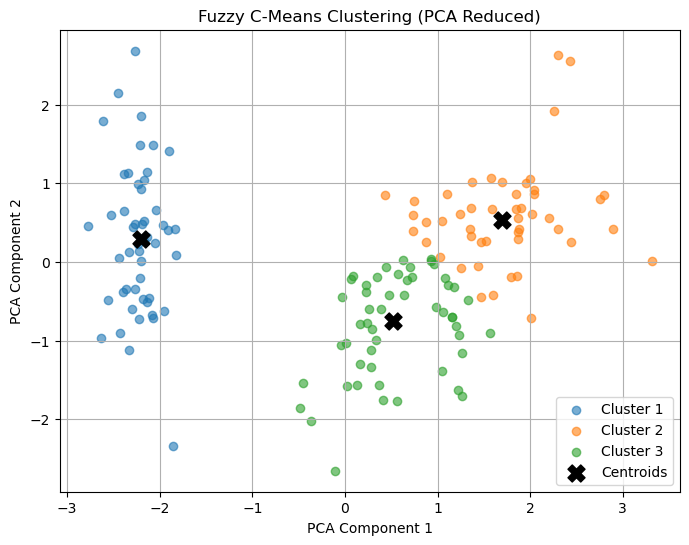

In [12]:
# 🔷 11. PCA Visualisation
# ========================

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data)
centroids_2d = pca.transform(centroids)

plt.figure(figsize=(8,6))
for i in range(c):
    plt.scatter(data_2d[clusters == i, 0], data_2d[clusters == i, 1], label=f'Cluster {i+1}', alpha=0.6)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='black', marker='X', s=150, label='Centroids')
plt.title('Fuzzy C-Means Clustering (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# 🔷 12. Comparison with KMeans
# ========================

kmeans = KMeans(n_clusters=3, random_state=42).fit(data)
kmeans_labels = kmeans.labels_
kmeans_cm = sklearn_cm(y, kmeans_labels)

print("🔷 KMeans Confusion Matrix:\n", kmeans_cm)
print("🔷 KMeans Accuracy: {:.2f}%".format(accuracy_score(y, kmeans_labels)*100))

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


🔷 KMeans Confusion Matrix:
 [[ 0 50  0]
 [39  0 11]
 [14  0 36]]
🔷 KMeans Accuracy: 24.00%
